In [24]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import seaborn as sns
# from cdo import *
# cdo = Cdo()

# from LinearRegression import linear_regression
dir_input = '/work/mh0033/m301036/LSAT/Data/Regrid/'

data_CRUTEMP  = dir_input+'tas_CRUTEMP_regrid.nc'
data_MLOST    = dir_input+'tas_MLOST_regrid.nc'
data_GISSTEMP = dir_input+'tas_GISS_regrid.nc'

In [25]:
#Using dateTime to select key period
tas_GISS    = xr.open_dataset(data_GISSTEMP)
tas_CRUTEMP = xr.open_dataset(data_CRUTEMP) 
tas_MLOST   = xr.open_dataset(data_MLOST,decode_times=False)
units, reference_data = tas_MLOST.time.attrs['units'].split('since')
display(tas_MLOST.time)

tas_CRUTEMP = tas_CRUTEMP.astype(np.float64)
# display(tas_GISS)
# display(tas_CRUTEMP)
# display(tas_MLOST)
# display(tas_GHCNv4)

tas_CRUTEMP = tas_CRUTEMP-273.15
# tas_MLOST_sel = tas_MLOST_sel-273.15
tas_GISS

<xarray.DataArray 'time' (time: 2079)>
array([18262., 18293., 18321., ..., 81449., 81480., 81508.])
Coordinates:
  * time     (time) float64 1.826e+04 1.829e+04 ... 8.148e+04 8.151e+04
Attributes:
    standard_name:  time
    long_name:      Time
    bounds:         time_bnds
    units:          days since 1800-1-1 00:00:0.0
    calendar:       gregorian
    axis:           T

<xarray.Dataset>
Dimensions:  (time: 1719, lon: 180, lat: 90)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 ... 2023-03-01
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    air      (time, lat, lon) float32 ...
Attributes: (12/13)
    CDI:            Climate Data Interface version 2.0.6 (https://mpimet.mpg....
    Conventions:    COARDS
    title:          GISS Surface Temperature Analysis (GISTEMP): 250km smooth...
    comments:       GISS Surface Temperature Analysis (GISTEMP): 250km smooth...
    platform:       Analysis
    Source:         http://data.giss.nasa.gov/gistemp/ source and http://data...
    ...             ...
    history:        Wed May 24 15:21:32 2023: cdo remapbil,r180x90 /work/mh00...
    dataset_title:  GISS Surface Temperature Analysis
    References:     https://www.psl.noaa.gov/data/gridded/data.gistemp.html
    update_date:    04/2023
    data_modified:  2023-04-13
    CDO:            Climate Data Operators version 2.0.6 (https://mpimet.mpg....

In [26]:
tas_MLOST_recon = pd.to_datetime(tas_MLOST.time.data, unit='D', origin=pd.Timestamp('1800-01-01'))
tas_MLOST_recon

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01'],
              dtype='datetime64[ns]', length=2079, freq=None)

In [27]:
tas_MLOST = tas_MLOST.assign_coords({"time":(tas_MLOST_recon)})
tas_MLOST

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) float64 ...
    air        (time, lat, lon) float32 ...
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [28]:
#Land only dataset
land_sea_mask=xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
# land_sea_mask.coords
display(land_sea_mask)

<xarray.Dataset>
Dimensions:  (time: 1, lon: 180, lat: 90)
Coordinates:
  * time     (time) float64 201.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    var1     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.0
    history:      Sun May 14 21:24:57 2023: cdo remapbil,r180x90 /pool/data/M...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...

In [29]:
mask_data = land_sea_mask['var1']
mask_data
# Align the time coordinates between the mask dataset and the original dataset
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values

# Align the time coordinates between the mask dataset and the original dataset
mask_data = mask_data.reindex(time=tas_MLOST['time'], method='nearest')

# Apply the land-sea mask to the original dataset

masked_MLOST_tas = tas_MLOST.where(mask_data == 1, drop=False)

# Print the resulting masked dataset
masked_MLOST_tas

<xarray.Dataset>
Dimensions:    (time: 2079, bnds: 2, lat: 90, lon: 180)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-03-01
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat, lon) float64 1.826e+04 1.826e+04 ... nan nan
    air        (time, lat, lon) float32 -0.1726 -0.1726 -0.1726 ... nan nan nan
Attributes: (12/24)
    CDI:                   Climate Data Interface version 2.0.6 (https://mpim...
    Conventions:           CF-1.0
    source:                https://www.ncdc.noaa.gov/noaa-merged-land-ocean-g...
    dataset_title:         NOAA Global Surface Temperature (NOAAGlobalTemp)
    keywords_vocabulary:   Climate and Forecast (CF) Standard Name Table (Ver...
    keywords:              Earth Science > Oceans > Ocean Temperature > Sea S...
    ...                    ...
    version:               V5.1
    comment:               Merged land ocean surface temperature anomalies. V...
    history:               Wed May 24 15:21:45 2023: cdo remapbil,r180x90 /wo...
    Source:                https://www.ncei.noaa.gov/data/noaa-global-surface...
    data_modified:         2023-04-18
    CDO:                   Climate Data Operators version 2.0.6 (https://mpim...

In [30]:
# tas_GISS_annual    = tas_GISS['air'].loc['1850-01-01':'2022-12-31',0:90,:]
#xr.DataArray.transpose(tas_GISS['lat'], transpose_coords=True, missing_dims='raise').groupby('time.year').groups
tas_CRUTEMP_annual = tas_CRUTEMP['tas'].loc['1850-01-01':'2022-12-31',0:90,:]
tas_MLOST_annual   = masked_MLOST_tas['air'].loc['1850-01-01':'2022-12-31',0:90,:]
tas_MLOST_annual,tas_CRUTEMP_annual

(<xarray.DataArray 'air' (time: 2076, lat: 45, lon: 180)>
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
 ...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan]

In [31]:
# tas_GISS_ano     = tas_GISS_annual-tas_GISS_annual.mean()
tas_CRUTEMP_ano  = tas_CRUTEMP_annual-tas_CRUTEMP_annual.mean()
tas_MLOST_ano    = tas_MLOST_annual-tas_MLOST_annual.mean()

year = np.arange(1850,2023,1)
lat = tas_CRUTEMP['lat']
lon = tas_CRUTEMP['lon']
tas_CRUTEMP_ano.min().values
# tas_GISS_ano.min().values

array(-17.42762838)

In [32]:
#Calculate the annual mean anomalies
# tas_GISS_annual    = tas_GISS_ano.mean(['lat','lon']).groupby('time.year').mean()
tas_CRUTEMP_annual = tas_CRUTEMP_ano.mean(['lat','lon']).groupby('time.year').mean()
tas_MLOST_annual   = tas_MLOST_ano.mean(['lat','lon']).groupby('time.year').mean()

# tas_GISS_annual.min().values

In [33]:
# tas_GISS_JJA     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([6,7,8])]
tas_CRUTEMP_JJA  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([6,7,8])]
tas_MLOST_JJA    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([6,7,8])]

#calculate the wintertime anomalies
# tas_GISS_DJF     = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([12,1,2])].loc['1850-12-01':'2022-03-01']
tas_CRUTEMP_DJF  = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([12,1,2])].loc['1850-12-01':'2022-03-01']
tas_MLOST_DJF    = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([12,1,2])].loc['1850-12-01':'2022-03-01']

# tas_GISS_MAM      = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([3,4,5])]
tas_CRUTEMP_MAM   = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([3,4,5])]
tas_MLOST_MAM     = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([3,4,5])]

# tas_GISS_SON      = tas_GISS_ano.loc[tas_GISS_ano.time.dt.month.isin([9,10,11])]
tas_CRUTEMP_SON   = tas_CRUTEMP_ano.loc[tas_CRUTEMP_ano.time.dt.month.isin([9,10,11])]
tas_MLOST_SON     = tas_MLOST_ano.loc[tas_MLOST_ano.time.dt.month.isin([9,10,11])]

In [34]:
#calculate annual mean for the time series of SAT
# tas_GISS_JJA_mean = tas_GISS_JJA.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GISS_JJA_mean)
tas_CRUTEMP_JJA_mean = tas_CRUTEMP_JJA.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_CRUTEMP_JJA_mean)
tas_MLOST_JJA_mean = tas_MLOST_JJA.mean(['lat','lon']).groupby('time.year').mean()
display(tas_MLOST_JJA_mean)

<xarray.DataArray 'air' (year: 173)>
array([-2.08241165e-01, -1.56532273e-01, -2.60914803e-01, -1.10742368e-01,
       -1.30742848e-01, -3.85659844e-01, -7.27352381e-01, -4.74272639e-01,
       -3.79012018e-01, -3.08031440e-01, -4.81370658e-01, -1.99025914e-01,
       -6.22502387e-01, -3.39434236e-01, -3.22068900e-01, -4.08807606e-01,
       -4.22091246e-01, -4.92275506e-01, -2.06606820e-01, -2.42964968e-01,
       -2.96049684e-01, -4.10477668e-01, -4.02600080e-01, -2.50407428e-01,
       -2.30824530e-01, -2.05444574e-01, -3.52183193e-01, -1.42657697e-01,
       -8.86820331e-02, -4.67912763e-01, -4.12763834e-01, -5.96159160e-01,
       -4.55032259e-01, -3.89331341e-01, -8.36527526e-01, -7.46650994e-01,
       -3.50271851e-01, -5.18697798e-01, -3.19159865e-01, -2.23756004e-02,
       -2.23504707e-01, -2.97316462e-01, -2.87549615e-01, -2.45628670e-01,
       -1.15436435e-01, -1.67299017e-01,  1.65155064e-02, -7.93540943e-03,
       -1.07988618e-01, -1.26903072e-01, -6.29074350e-02,  8.79934058e-02,
       -2.75534540e-01, -3.07366937e-01, -3.33161145e-01, -1.68468341e-01,
        8.84764418e-02, -4.92971152e-01, -6.09166771e-02, -1.74830496e-01,
       -8.81800652e-02, -1.89400509e-01, -5.48383057e-01, -3.56986254e-01,
       -2.78558522e-01,  1.03537366e-03, -2.84443825e-01, -2.33232692e-01,
       -4.72545147e-01, -1.41666636e-01, -9.54940394e-02,  1.12809278e-01,
       -1.00489803e-01, -9.16743651e-02, -1.06723182e-01, -2.37569705e-01,
       -1.19606756e-01,  2.85205394e-02, -7.05164894e-02, -2.59408027e-01,
...
        2.14109570e-02, -6.80650920e-02,  2.58069545e-01, -4.41377647e-02,
       -2.10175514e-01,  1.45553738e-01,  2.58406341e-01,  5.11177003e-01,
        3.45687002e-01,  1.75011441e-01, -1.25626266e-01,  1.83675349e-01,
        2.10657120e-02,  2.51334518e-01,  1.90378666e-01,  1.26523152e-01,
        4.45216261e-02,  8.25263709e-02, -1.38768405e-01, -2.15963244e-01,
        2.17969656e-01, -1.21709146e-02, -2.13474676e-01, -4.25278163e-03,
        2.80123204e-02,  5.89454733e-02, -1.19765855e-01,  2.84403652e-01,
        2.35424247e-02,  2.21786499e-01, -1.53001010e-01,  2.81693697e-01,
       -2.34254643e-01,  1.53467521e-01,  3.23232055e-01,  5.72977364e-01,
        1.15018986e-01,  4.33641583e-01,  3.02736878e-01,  1.49079219e-01,
        1.77814499e-01,  3.43168616e-01,  7.68123806e-01,  4.42748189e-01,
        6.34553969e-01,  7.77232647e-01, -1.56176031e-01,  3.32799613e-01,
        5.66313267e-01,  7.91657984e-01,  3.82688016e-01,  5.99361420e-01,
        1.27642834e+00,  6.86291754e-01,  7.81537056e-01,  1.03608525e+00,
        1.03708327e+00,  9.69200134e-01,  5.80104411e-01,  1.02403390e+00,
        1.09399784e+00,  1.11964607e+00,  9.84817982e-01,  8.46388280e-01,
        1.42463350e+00,  1.30450451e+00,  1.56012881e+00,  1.05937040e+00,
        1.09627759e+00,  1.25333214e+00,  1.57707167e+00,  1.29065645e+00,
        1.26027071e+00,  1.41779482e+00,  1.43878734e+00,  1.68790340e+00,
        1.59851825e+00], dtype=float32)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022

In [35]:
# tas_GISS_SON_mean = tas_GISS_SON.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GISS_SON_mean)
tas_CRUTEMP_SON_mean = tas_CRUTEMP_SON.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_CRUTEMP_SON_mean)
tas_MLOST_SON_mean = tas_MLOST_SON.mean(['lat','lon']).groupby('time.year').mean()
display(tas_MLOST_SON_mean)

<xarray.DataArray 'air' (year: 173)>
array([-0.46845695, -0.1848792 , -0.46339417, -0.22215343, -0.04935475,
       -0.28690067, -0.7480462 , -0.7050871 , -0.4216934 , -0.21955031,
       -0.49139372, -0.5552482 , -0.44585285, -0.28845537, -0.7784949 ,
       -0.31816384, -0.3448398 , -0.21067218, -0.48979044, -0.18702775,
       -0.6493999 , -0.6122778 , -0.37910113, -0.3941371 , -0.21623026,
       -1.0166866 , -0.6510202 , -0.2365917 , -0.16017862, -0.42830834,
       -0.5742007 , -0.7829044 , -0.76809406, -0.7670727 , -0.79479885,
       -0.6485397 , -0.37007144, -0.50418586, -0.55446005, -0.60271734,
       -0.4307609 , -0.6189056 , -0.5065771 , -0.22481656, -0.47363797,
       -0.1741399 , -0.2729177 , -0.07977824, -0.5574921 ,  0.39554325,
       -0.04711757, -0.25596508, -0.7204542 , -0.44179893, -0.11187813,
        0.03848635, -0.21494408, -0.35150054, -0.31679025, -0.03921143,
       -0.41115788, -0.13491967, -0.8710936 , -0.28565514, -0.22105366,
       -0.2528218 , -0.13399656, -0.1787708 , -0.04292126, -0.15578097,
       -0.5106523 , -0.02649205, -0.1462981 ,  0.33268622,  0.3728926 ,
        0.3237859 ,  0.3052304 ,  0.43250266,  0.25884798,  0.24814658,
        0.31059486,  0.822732  ,  0.30639273,  0.02448438,  0.4517703 ,
       -0.11413795,  0.3285276 ,  0.65796787,  0.8575507 ,  0.25607738,
        0.30598637,  0.14396898,  0.42285624,  0.71388847,  0.49477646,
        0.33904767,  0.1032114 ,  0.76686496,  0.6186468 ,  0.31645158,
       -0.16249904,  0.49383292, -0.13150047,  0.31875473,  0.67792434,
        0.24037969, -0.35742953,  0.05705342, -0.05126407, -0.06905664,
        0.01017097, -0.11512217,  0.25912416,  0.70830965, -0.23290877,
       -0.09977281, -0.02888279,  0.47029468, -0.28794977,  0.17891519,
        0.07067142,  0.49962568, -0.38543963,  0.2174242 , -0.2033549 ,
        0.15496492, -0.35337332,  0.31813142,  0.35576454,  0.46802628,
        0.53769535,  0.64419943, -0.10551473,  0.9592266 , -0.01740149,
        0.22796302,  0.14667872,  0.21334845,  0.8268854 ,  0.41150907,
        0.54427373,  0.8352408 , -0.11157799, -0.05066397,  0.89750594,
        1.0960239 ,  0.31790307,  0.86744136,  0.7005694 ,  0.87960166,
        0.28879383,  1.3305887 ,  1.0836569 ,  1.2405373 ,  1.2747749 ,
        1.794603  ,  1.2475528 ,  1.385254  ,  1.5039649 ,  1.2553085 ,
        1.855518  ,  1.4448828 ,  1.4611131 ,  1.4261078 ,  1.0068532 ,
        1.6191033 ,  1.6115123 ,  1.5838561 ,  1.4282027 ,  1.8082434 ,
        1.9575871 ,  2.0055792 ,  1.746509  ], dtype=float32)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022

In [36]:
# tas_GISS_MAM_mean = tas_GISS_MAM.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GISS_MAM_mean)
tas_CRUTEMP_MAM_mean = tas_CRUTEMP_MAM.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_CRUTEMP_MAM_mean)
tas_MLOST_MAM_mean = tas_MLOST_MAM.mean(['lat','lon']).groupby('time.year').mean()
display(tas_MLOST_MAM_mean)

<xarray.DataArray 'air' (year: 173)>
array([-0.77590436, -0.5700169 , -0.6715912 , -0.83105665, -0.5676013 ,
       -0.4739271 , -0.8822748 , -0.916133  , -0.44879374, -0.23110785,
       -0.74076563, -0.5208385 , -0.7608504 , -0.20168291, -0.56751937,
       -0.83535415, -0.7898801 , -1.0625242 , -0.3456869 , -0.61383176,
       -0.55491143, -0.48467553, -0.79148126, -1.1067446 , -0.52826095,
       -0.82493514, -0.7472105 , -0.67103195, -0.1719529 , -0.56076   ,
       -0.948555  , -0.6349167 , -0.8285668 , -0.76256895, -1.4148192 ,
       -1.0839158 , -0.8044265 , -0.68612653, -1.0003194 , -0.34287795,
       -0.6740176 , -0.68166107, -0.8430157 , -0.5643483 , -0.24932647,
       -0.5242651 , -0.8191616 , -0.45729998, -1.1073102 , -0.73321563,
       -0.18435971,  0.02881411, -1.0326734 , -0.5885699 , -0.7005296 ,
       -0.82877904, -0.11934789, -0.7921448 , -0.90920275, -1.1837896 ,
       -0.5705996 , -0.87249327, -0.762698  , -0.73546976, -0.6324623 ,
       -0.02719813, -0.6404677 , -0.97523016, -0.91285706, -0.74612886,
       -0.18881203, -0.31552798, -0.34226164, -0.9606467 , -0.24973202,
       -0.40676126, -0.02329656, -0.5926629 , -0.6276365 , -0.45992932,
       -0.17793567, -0.6033793 , -0.09122095, -0.65883905, -0.42466953,
       -0.55635285, -0.29852498, -0.43431893,  0.41544637, -0.11357739,
        0.13685872, -0.18977265, -0.2886395 ,  0.2824593 ,  0.24608892,
       -0.05680455,  0.08471438,  0.2412393 , -0.10039205, -0.05675977,
       -0.27358353, -0.15279792, -0.33074835,  0.55148035, -0.44357964,
       -0.70831877, -0.7258598 , -0.48448   , -0.38610348, -0.09690455,
       -0.8472007 , -0.0817846 ,  0.26199865, -0.46556476, -1.0042645 ,
       -0.26070002, -0.58442193,  0.20322043,  0.36538413, -0.61698276,
       -0.34852925, -0.36192808, -0.27440467,  0.31573048, -0.09554837,
        0.32638857, -0.22959924,  0.6540158 ,  0.01038524, -0.2374469 ,
        0.07785641,  0.72572416, -0.10320517, -0.02265359,  0.24613559,
        0.11098623,  0.31933722, -0.13078272,  0.60827756,  0.45552477,
        1.3725238 ,  0.56544524,  0.17648967,  0.48984036,  0.6315772 ,
        0.8682448 ,  0.31091067,  0.9047291 ,  0.9333045 ,  0.40576634,
        1.3756067 ,  0.96283215,  0.75334483,  0.83266133,  0.76375085,
        1.335061  ,  0.9622359 ,  1.3831962 ,  1.2939337 ,  0.7656788 ,
        1.6043459 ,  1.2761253 ,  1.4344765 ,  0.9131085 ,  1.5670067 ,
        1.5952438 ,  2.292939  ,  1.7349907 ,  1.2145065 ,  1.855848  ,
        2.1024098 ,  1.6020628 ,  1.6268517 ], dtype=float32)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2018 2019 2020 2021 2022

In [37]:
#calculate DJF mean for the time series of SAT
# tas_GISS_DJF_mean = tas_GISS_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_GISS_DJF_mean)
tas_CRUTEMP_DJF_mean = tas_CRUTEMP_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_CRUTEMP_DJF_mean)
tas_MLOST_DJF_mean = tas_MLOST_DJF.mean(['lat','lon']).groupby('time.year').mean()
# display(tas_MLOST_DJF_mean)

In [38]:
#Calculate the 15yr running trend time series
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the window size (35 years)
window_size = 35

# Calculate the number of data points in the window
num_points  = len(tas_CRUTEMP_annual)
num_windows = num_points - window_size + 1

# Initialize an array to store the trend values
# trend = np.zeros(num_windows)
# for i in range(num_windows):
#     CRUTEMP_window_data = tas_GISS_annual[i:i+window_size]
#     time = np.arange(len(GISS_window_data))
#     trend[i] = np.polyfit(time, GISS_window_data, 1)[0]

# print(trend)
# print(len(trend))

trend1 = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_data = tas_MLOST_annual[i:i+window_size]
    time = np.arange(len(MLOST_window_data))
    trend1[i] = np.polyfit(time, MLOST_window_data, 1)[0]

print(trend1)
print(len(trend1))

[-0.00788948 -0.00959513 -0.00845462 -0.00867604 -0.00888956 -0.00662459
 -0.00573621 -0.00616614 -0.00691191 -0.0069697  -0.00369465 -0.00389314
 -0.00260844 -0.0021757   0.00031126  0.00131036  0.00260743  0.00485026
  0.00454651  0.00609061  0.00753645  0.00800657  0.00901446  0.00769969
  0.00798469  0.00895423  0.00789447  0.00716285  0.00674703  0.00873774
  0.01018471  0.01082667  0.01005751  0.00887871  0.00699197  0.00482458
  0.00336637  0.00488151  0.00396674  0.00316177  0.00494355  0.00605454
  0.0078538   0.007358    0.00731447  0.00700131  0.0079169   0.00979975
  0.01217108  0.01078898  0.01295142  0.01374822  0.01529061  0.01577451
  0.01867041  0.02047299  0.0219023   0.02340325  0.02246296  0.02367246
  0.02440496  0.02372065  0.02261947  0.0211816   0.02069093  0.02055522
  0.0186459   0.01669152  0.01372213  0.01313865  0.01077483  0.00833712
  0.00604479  0.00369691  0.00218664  0.00174892  0.00101548  0.00137663
  0.00159305  0.00223063 -0.00244898 -0.0042313  -0

In [39]:
trend2 = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_data = tas_CRUTEMP_annual[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_data))
    trend2[i] = np.polyfit(time, CRUTEMP_window_data, 1)[0]

print(trend2)
print(len(trend2))

[ 0.0013701  -0.0021744  -0.00164608 -0.00122314 -0.00556029 -0.0035127
 -0.0045315  -0.00585038 -0.00643638 -0.00924198 -0.00433544 -0.00734562
 -0.00561212 -0.00429107  0.00204391 -0.00129888  0.00100809  0.00472563
  0.00130488  0.00560071  0.00580253  0.00480086  0.00360705  0.00438422
  0.00514593  0.00638898  0.00500449  0.00442808  0.00288104  0.00698428
  0.00717335  0.00794953  0.00682671  0.00647773  0.00656654  0.00576235
  0.00529954  0.00788028  0.00758817  0.00491314  0.00515958  0.00807543
  0.00828641  0.00669538  0.0041141   0.00312973  0.00358633  0.0050976
  0.0071209   0.00664357  0.00936354  0.01093839  0.01288071  0.01129308
  0.01422775  0.01491823  0.01375853  0.01401167  0.0110343   0.01189244
  0.01267902  0.01274302  0.01255708  0.00961803  0.01110512  0.01222352
  0.01010568  0.00902054  0.00451115  0.00533119  0.00252359  0.00182906
  0.00123245  0.00050937  0.00036737 -0.00038591  0.00025949  0.00093737
  0.00103116  0.00121183 -0.0030997  -0.00350208 -0.0

In [40]:
#Calculate JJA and DJF trend
# trend_JJA = np.zeros(num_windows)
# for i in range(num_windows):
#     GISS_window_jja = tas_GISS_JJA_mean[i:i+window_size]
#     time = np.arange(len(GISS_window_jja))
#     trend_JJA[i] = np.polyfit(time, GISS_window_jja, 1)[0]

# print(trend_JJA)
# print(len(trend_JJA))

# trend_DJF = np.zeros(num_windows)
# for i in range(num_windows):
#     GISS_window_djf = tas_GISS_DJF_mean[i:i+window_size]
#     time = np.arange(len(GISS_window_djf))
#     trend_DJF[i] = np.polyfit(time, GISS_window_djf, 1)[0]

# print(trend_DJF)
# print(len(trend_DJF))

# trend_MAM = np.zeros(num_windows)
# for i in range(num_windows):
#     GISS_window_MAM = tas_GISS_MAM_mean[i:i+window_size]
#     time = np.arange(len(GISS_window_MAM))
#     trend_MAM[i] = np.polyfit(time, GISS_window_MAM, 1)[0]

# print(trend_MAM)
# print(len(trend_MAM))

# trend_SON = np.zeros(num_windows)
# for i in range(num_windows):
#     GISS_window_SON = tas_GISS_SON_mean[i:i+window_size]
#     time = np.arange(len(GISS_window_SON))
#     trend_SON[i] = np.polyfit(time, GISS_window_SON, 1)[0]

# print(trend_SON)
# print(len(trend_SON))

In [41]:
trend1_JJA = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_jja = tas_MLOST_JJA_mean[i:i+window_size]
    time = np.arange(len(MLOST_window_jja))
    trend1_JJA[i] = np.polyfit(time, MLOST_window_jja, 1)[0]

print(trend1_JJA)
print(len(trend1_JJA))

trend1_DJF = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_djf = tas_MLOST_DJF_mean[i:i+window_size]
    time = np.arange(len(MLOST_window_djf))
    trend1_DJF[i] = np.polyfit(time, MLOST_window_djf, 1)[0]

print(trend1_DJF)
print(len(trend1_DJF))

trend1_MAM = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_MAM = tas_MLOST_MAM_mean[i:i+window_size]
    time = np.arange(len(MLOST_window_MAM))
    trend1_MAM[i] = np.polyfit(time, MLOST_window_MAM, 1)[0]

print(trend1_MAM)
print(len(trend1_MAM))

trend1_SON = np.zeros(num_windows)
for i in range(num_windows):
    MLOST_window_SON = tas_MLOST_SON_mean[i:i+window_size]
    time = np.arange(len(MLOST_window_SON))
    trend1_SON[i] = np.polyfit(time, MLOST_window_SON, 1)[0]

print(trend1_SON)
print(len(trend1_SON))

[-4.05512086e-03 -5.18276906e-03 -4.01136535e-03 -4.11401964e-03
 -2.43711324e-03  6.10589062e-04  1.38488296e-03  3.94512004e-05
 -1.03897696e-04  3.80379234e-04  1.80514218e-03  2.05501301e-03
  4.51580279e-03  4.66460840e-03  5.59205692e-03  6.45216222e-03
  7.12500235e-03  8.35255076e-03  7.35226263e-03  7.58002623e-03
  7.52986599e-03  8.02156821e-03  9.12413213e-03  7.35785385e-03
  8.44164977e-03  9.02865759e-03  1.01405681e-02  9.99777066e-03
  9.15636622e-03  9.61216990e-03  8.60450649e-03  9.15326401e-03
  7.30200431e-03  6.31885615e-03  4.46526127e-03  1.95581685e-03
 -7.52379810e-05  7.01781144e-04 -5.15830698e-04 -8.02535752e-04
  2.71767985e-04 -2.67476521e-04 -6.13213031e-04 -2.54115491e-04
 -2.43791799e-04 -5.25571212e-04  6.85712675e-04  4.43686857e-03
  7.03669744e-03  7.35456467e-03  7.91196635e-03  9.17577772e-03
  1.24987406e-02  1.33212608e-02  1.37957326e-02  1.44972640e-02
  1.51709349e-02  1.80196272e-02  1.63289499e-02  1.70107254e-02
  1.68862739e-02  1.75158

In [42]:
trend2_JJA = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_jja = tas_CRUTEMP_JJA_mean[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_jja))
    trend2_JJA[i] = np.polyfit(time, CRUTEMP_window_jja, 1)[0]

print(trend2_JJA)
print(len(trend2_JJA))

trend2_DJF = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_djf = tas_CRUTEMP_DJF_mean[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_djf))
    trend2_DJF[i] = np.polyfit(time, CRUTEMP_window_djf, 1)[0]

print(trend2_DJF)
print(len(trend2_DJF))

trend2_MAM = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_MAM = tas_CRUTEMP_MAM_mean[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_MAM))
    trend2_MAM[i] = np.polyfit(time, CRUTEMP_window_MAM, 1)[0]

print(trend2_MAM)
print(len(trend2_MAM))

trend2_SON = np.zeros(num_windows)
for i in range(num_windows):
    CRUTEMP_window_SON = tas_CRUTEMP_SON_mean[i:i+window_size]
    time = np.arange(len(CRUTEMP_window_SON))
    trend2_SON[i] = np.polyfit(time, CRUTEMP_window_SON, 1)[0]

print(trend2_SON)
print(len(trend2_SON))

[-0.01648955 -0.01355065 -0.01516772 -0.01459952 -0.01584985 -0.01483686
 -0.01256657 -0.01458996 -0.0147358  -0.01206437 -0.00736382 -0.01011164
 -0.00412162 -0.00511288 -0.00465059 -0.00834175 -0.00786452 -0.00347903
 -0.00825682 -0.00407034 -0.00917062 -0.00753793 -0.00756284 -0.00857073
 -0.00665146 -0.0064887  -0.00599432 -0.00187599 -0.00158305 -0.00077451
 -0.00036923 -0.00144357 -0.00158682 -0.00060212 -0.0013182  -0.0017038
 -0.00213047 -0.00076369  0.00026715 -0.00324279 -0.00297025 -0.00095313
 -0.0028439  -0.00198183 -0.00365751 -0.00296705 -0.00100629  0.00340342
  0.00719891  0.0096546   0.01036803  0.01259005  0.01990123  0.02061306
  0.02126287  0.02088942  0.02218992  0.02335052  0.02070456  0.01981928
  0.01853518  0.01761315  0.01795234  0.01557526  0.0139281   0.01275282
  0.00899344  0.00673074  0.00758381  0.00674835  0.0059645   0.00511738
  0.00361099  0.00312493 -0.00024372 -0.00128274 -0.00155935 -0.00354656
 -0.00453661 -0.00802412 -0.01045032 -0.01134104 -0.

In [43]:
# time_series_GISS_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GISS_DJF_mean})
# time_series_GISS_DJF.to_csv('GISS_DJF_NH.txt', sep='\t', index=False)

# time_series_CRUTEMP_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_CRUTEMP_DJF_mean})
# time_series_CRUTEMP_DJF.to_csv('CRUTEMP_DJF_NH.txt', sep='\t', index=False)

# time_series_GHCNv4_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_GHCNv4_DJF_mean})
# time_series_GHCNv4_DJF.to_csv('GHCNv4_DJF_NH.txt', sep='\t', index=False)

# time_series_MLOST_DJF = pd.DataFrame({'time': np.arange(1900,2015,1), 'values': tas_MLOST_DJF_mean})
# time_series_MLOST_DJF.to_csv('MLOST_DJF_NH.txt', sep='\t', index=False)

In [44]:
len(np.arange(1850,1990,1))

140

In [45]:
out_dir = "/work/mh0033/m301036/josie/LSAT/1850-2100Analyses/Data-output/"
# trend_GISS_annual = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend})
# trend_GISS_annual.to_csv(out_dir+'GISS_annual_NH_35yr_trend.txt', sep='\t', index=False)

# trend_GISS_JJA = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend_JJA})
# trend_GISS_JJA.to_csv(out_dir+'GISS_JJA_NH_35yr_trend.txt', sep='\t', index=False)

# trend_GISS_DJF = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend_DJF})
# trend_GISS_DJF.to_csv(out_dir+'GISS_DJF_NH_35yr_trend.txt', sep='\t', index=False)

In [50]:
trend_MLOST_annual = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend1})
trend_MLOST_annual.to_csv(out_dir+'MLOST_annual_NH_35yr_trend.txt', sep='\t', index=False)

trend_MLOST_JJA = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend1_JJA})
trend_MLOST_JJA.to_csv(out_dir+'MLOST_JJA_NH_35yr_trend.txt', sep='\t', index=False)

trend_MLOST_DJF = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend1_DJF})
trend_MLOST_DJF.to_csv(out_dir+'MLOST_DJF_NH_35yr_trend.txt', sep='\t', index=False)

trend_MLOST_MAM = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend1_MAM})
trend_MLOST_MAM.to_csv(out_dir+'MLOST_MAM_NH_35yr_trend.txt', sep='\t', index=False)

trend_MLOST_SON = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend1_SON})
trend_MLOST_SON.to_csv(out_dir+'MLOST_SON_NH_35yr_trend.txt', sep='\t', index=False)

In [51]:
trend_CRUTEMP_annual = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend2})
trend_CRUTEMP_annual.to_csv(out_dir+'CRUTEMP_annual_NH_35yr_trend.txt', sep='\t', index=False)

trend_CRUTEMP_JJA = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend2_JJA})
trend_CRUTEMP_JJA.to_csv(out_dir+'CRUTEMP_JJA_NH_35yr_trend.txt', sep='\t', index=False)

trend_CRUTEMP_DJF = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend2_DJF})
trend_CRUTEMP_DJF.to_csv(out_dir+'CRUTEMP_DJF_NH_35yr_trend.txt', sep='\t', index=False)

trend_CRUTEMP_MAM = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend2_MAM})
trend_CRUTEMP_MAM.to_csv(out_dir+'CRUTEMP_MAM_NH_35yr_trend.txt', sep='\t', index=False)

trend_CRUTEMP_SON = pd.DataFrame({'time': np.arange(1850,1989,1), 'values': trend2_SON})
trend_CRUTEMP_SON.to_csv(out_dir+'CRUTEMP_SON_NH_35yr_trend.txt', sep='\t', index=False)

<function matplotlib.pyplot.show(close=None, block=None)>

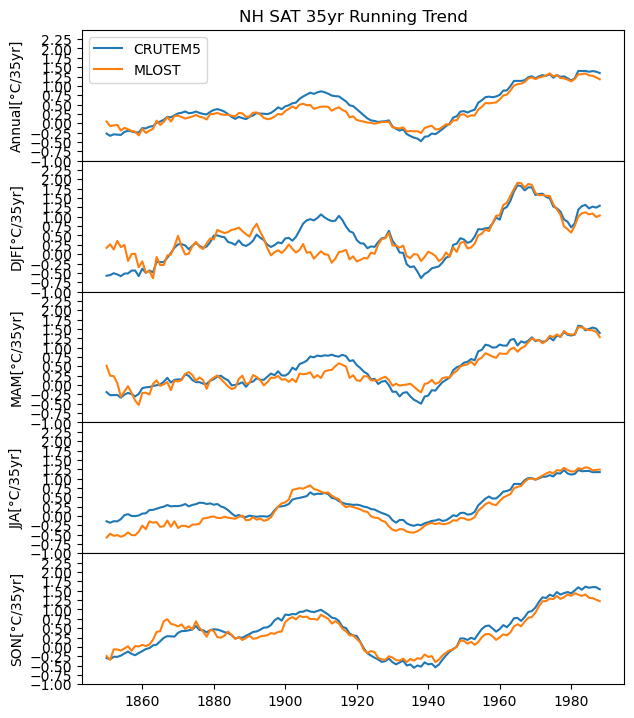

In [49]:
fig,axs = plt.subplots(5,1, figsize=(7,8.5), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0)
# plt.style.use('seaborn-bright')
x = np.arange(1850,1989,1)

# axs[0].plot(x, trend*35.0, label='GISTEMP')
axs[0].plot(x, trend1*35.0, label='CRUTEM5')
axs[0].plot(x, trend2*35.0, label='MLOST')

axs[0].set_ylabel("Annual[°C/35yr]")
axs[0].set_title('NH SAT 35yr Running Trend')

# axs[1].plot(x, trend_JJA*35.0)
axs[1].plot(x, trend1_DJF*35.0)
axs[1].plot(x, trend2_DJF*35.0)
# axs[1].plot(x, tas_GHCNv4_DJF_mean)
axs[1].set_ylabel("DJF[°C/35yr]")
# axs[1].set_title('1900-2014 DJF NH SAT')

axs[0].set_yticks(np.arange(-1.0,2.5, 0.25))
axs[0].set_ylim(-1.0,2.5)

# axs[2].plot(x, trend_DJF*35.0)
axs[2].plot(x, trend1_MAM*35.0)
axs[2].plot(x, trend2_MAM*35.0)
# axs[2].plot(x, tas_GHCNv4_MAM_mean)
axs[2].set_ylabel("MAM[°C/35yr]")

axs[3].plot(x, trend1_JJA*35.0)
axs[3].plot(x, trend2_JJA*35.0)
# axs[2].plot(x, tas_GHCNv4_JJA_mean)
axs[3].set_ylabel("JJA[°C/35yr]")

axs[4].plot(x, trend1_SON*35.0)
axs[4].plot(x, trend2_SON*35.0)
# axs[2].plot(x, tas_GHCNv4_SON_mean)
axs[4].set_ylabel("SON[°C/35yr]")
# axs[0].legend(loc='upper left', bbox_to_anchor=(1.0, 0.95, 0.15, 0.15))
axs[0].legend()

# axs[2].set_title('1900-2014 DJF NH SAT')

# Temperature vs time plot - illustrates the "x" and "add_legend" kwargs
# air.isel(lon=30, lat=isel_lats).plot.line(ax=ax2, x="time", add_legend=False)
# ax2.set_ylabel("")
# sns.set_context('poster')

# fig.savefig("Obs_NH_15yr_SAT_trend.png")
fig.savefig('./Obs_NH_35yr_SAT_trend.png', format='png')
plt.show
# fig.tight_layout()